In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# 이미지 로드 및 라벨링 함수
def load_images_and_labels(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.startswith('image_damaged_') or filename.startswith('rembg_image_damaged_'):
            label = 'damaged'
        elif filename.startswith('image_normal_') or filename.startswith('rembg_image_normal_'):
            label = 'normal'
        else:
            continue
        
        img_path = os.path.join(directory, filename)
        img = load_img(img_path)

        if img.size < (50, 50):
            continue
        else:
            img = load_img(img_path, target_size=(224, 224))

        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(label)
    
    return np.array(images), np.array(labels)

In [3]:
# 이미지 및 라벨 로드
image_directory = 'images'
X, y = load_images_and_labels(image_directory)

In [4]:
# 라벨 인코딩
le = LabelEncoder()
y = le.fit_transform(y)

In [5]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape

((2312, 224, 224, 3), (2312,))

In [6]:
# 데이터 증강
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

In [7]:
# CNN 모델 정의
model = Sequential([
    Conv2D(16, (5, 5), activation=LeakyReLU(alpha=0.01), input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (5, 5), activation=LeakyReLU(alpha=0.01)),
    MaxPooling2D(2, 2),
    Conv2D(64, (5, 5), activation=LeakyReLU(alpha=0.01)),
    MaxPooling2D(2, 2),
    Conv2D(128, (5, 5), activation=LeakyReLU(alpha=0.01)),
    MaxPooling2D(2, 2),
    Conv2D(256, (5, 5), activation=LeakyReLU(alpha=0.01)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 64)        0

In [9]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
# 콜백 함수 정의
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=False) #,
    # ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True)
]

In [11]:
# 모델 학습
history = model.fit(
    X_train,
    y_train,
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/20


72/72 [==============================] - 23s 303ms/step - loss: 4.3558 - accuracy: 0.5117 - val_loss: 0.6921 - val_accuracy: 0.5208
Epoch 2/20
72/72 [==============================] - 21s 294ms/step - loss: 0.6847 - accuracy: 0.5484 - val_loss: 0.6752 - val_accuracy: 0.5104
Epoch 3/20
72/72 [==============================] - 22s 304ms/step - loss: 0.6717 - accuracy: 0.5928 - val_loss: 0.6565 - val_accuracy: 0.6107
Epoch 4/20
72/72 [==============================] - 21s 298ms/step - loss: 0.6546 - accuracy: 0.6111 - val_loss: 0.6815 - val_accuracy: 0.4948
Epoch 5/20
72/72 [==============================] - 21s 299ms/step - loss: 0.6476 - accuracy: 0.6247 - val_loss: 0.6755 - val_accuracy: 0.6263
Epoch 6/20
72/72 [==============================] - 22s 300ms/step - loss: 0.6240 - accuracy: 0.6670 - val_loss: 0.6473 - val_accuracy: 0.5952
Epoch 7/20
72/72 [==============================] - 22s 301ms/step - loss: 0.6103 - accuracy: 0.6716 - val_loss: 0.6364 - val_accuracy: 0.62

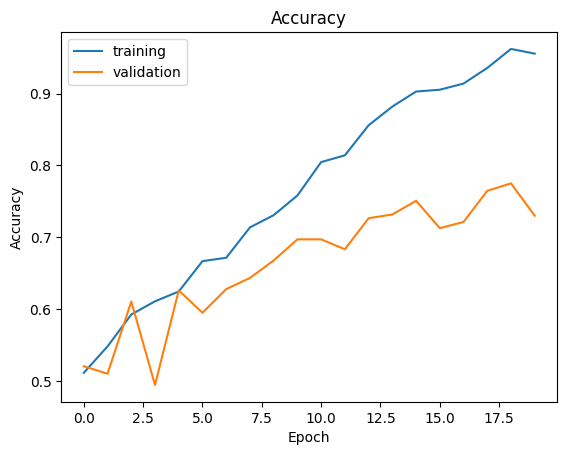

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()